In [1]:
get_ipython().run_cell_magic('capture', '', "%logstop\n%logstart -t -r -q ipython_command_log.py global\n\n#- IRONHACKS RESEARCH TRACKING CODE\n#----------------------------------\n# The following code is used to help our research team understand how you \n# our notebook environment. We do not collect any personal information with\n# the following code, it is used to measure when and how often you work on\n# your submission files.\n\nimport os\nfrom datetime import datetime\nimport IPython.core.history as history\n\nha = history.HistoryAccessor()\nha_tail = ha.get_tail(1)\nha_cmd = next(ha_tail)\nsession_id = str(ha_cmd[0])\ncommand_id = str(ha_cmd[1])\ntimestamp = datetime.utcnow().isoformat()\nhistory_line = ','.join([session_id, command_id, timestamp]) + '\\n'\nlogfile = open(os.environ['HOME']+'/ipython_session_log.csv', 'a')\nlogfile.write(history_line)\nlogfile.close()\n")

In [2]:
get_ipython().run_cell_magic('capture', '', "\n#- INSTALL ADDITIONAL LIBRARIES IF REQUIRED\n#------------------------------------------\n# This is normally not required. The hub environment comes preinstaled with \n# many packages that you can already use without setup. In case there is some\n# other library you would like to use that isn't on the list you run this command\n# once to install them.  If it is already installed this command has no effect.\n\n!python3 -m pip install pandas\n!pip install db-dtypes\n")

- IMPORT THE LIBRARIES YOU WILL USE
------------------------------------------
You only need to import packages one time per notebook session. To keep your
notebook clean and organized you can handle all imports at the top of your file.
The following are included for example purposed, feel free to modify or delete 
anything in this section.

In [3]:
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from google.cloud import bigquery
from google.oauth2 import service_account
from google.cloud.bigquery import magics
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from statsmodels.formula.api import ols
from pandas import Series, DataFrame

CONFIGURE THE BIGQUERY SETTINGS

In [4]:
BIGQUERY_PROJECT = 'ironhacks-data'
bigquery_client = bigquery.Client(project=BIGQUERY_PROJECT)

In [5]:
query = """
SELECT *
FROM `ironhacks-data.ironhacks_competition.unemployment_data`
"""

In [6]:
query_job = bigquery_client.query(query)
unemployment_data = query_job.to_dataframe()
unemployment_data.head()

,uu_id,timeperiod,week_number,countyfips,tract,tract_name,total_claims,edu_8th_or_less,edu_grades_9_11,edu_hs_grad_equiv,...,gender_female,gender_male,gender_na,race_amerindian,race_asian,race_black,race_noanswer,race_hawaiiannative,race_other,race_white
0,f013068de98db1470bd986137a0c6d23,20220416,16,18003,900,"Census Tract 9, Allen County, Indiana",22,0,<NA>,14,...,<NA>,<NA>,0,0,0,11,0,0,<NA>,<NA>
1,21957d5517323845818d87623589e1ba,20220319,12,18089,10400,"Census Tract 104, Lake County, Indiana",111,0,<NA>,108,...,76,35,0,0,0,<NA>,<NA>,0,0,0
2,6a5609f385912113b6f1014b958ed748,20220326,13,18089,11500,"Census Tract 115, Lake County, Indiana",39,0,<NA>,<NA>,...,<NA>,<NA>,0,0,0,39,0,0,0,0
3,46b2882ec4c373527ec33f7bd4f1388d,20220716,29,18089,20700,"Census Tract 207, Lake County, Indiana",14,0,<NA>,<NA>,...,<NA>,<NA>,0,0,<NA>,10,0,0,<NA>,<NA>
4,37495d17e82f7df326bfc2c4c090f7b7,20220409,15,18089,21900,"Census Tract 219, Lake County, Indiana",155,0,<NA>,69,...,90,65,0,0,0,135,<NA>,<NA>,<NA>,<NA>


In [7]:
query2 = """
SELECT *
FROM `ironhacks-data.ironhacks_competition.wage_data`
"""

In [8]:
query_job2 = bigquery_client.query(query2)
wage_data = query_job2.to_dataframe()
wage_data.head()

,uu_id,countyfips,tract,tract_name,average_wage
0,585f8731c2255d6b3f817a31180848b9,18177,200,"Census Tract 2, Wayne County, Indiana",6612.000000
1,8c9d2aa90948679972a9382aadcc6001,18177,900,"Census Tract 9, Wayne County, Indiana",9883.250000
2,0f3d45341a5b113b813ffb7be7f58bab,18183,50300,"Census Tract 503, Whitley County, Indiana",13992.250000
3,fb55464f8e34af6d750d06968bf719b8,18183,50400,"Census Tract 504, Whitley County, Indiana",13613.500000
4,983badfd7b568728e39a2344a9006078,18001,30200,"Census Tract 302, Adams County, Indiana",11816.666667


In [9]:
wage_data[wage_data.isnull().any(axis=1)]

,uu_id,countyfips,tract,tract_name,average_wage


In [10]:
wage_data2 = wage_data.fillna({'average_wage': wage_data.average_wage.mean()})
wage_data2.head()

,uu_id,countyfips,tract,tract_name,average_wage
0,585f8731c2255d6b3f817a31180848b9,18177,200,"Census Tract 2, Wayne County, Indiana",6612.000000
1,8c9d2aa90948679972a9382aadcc6001,18177,900,"Census Tract 9, Wayne County, Indiana",9883.250000
2,0f3d45341a5b113b813ffb7be7f58bab,18183,50300,"Census Tract 503, Whitley County, Indiana",13992.250000
3,fb55464f8e34af6d750d06968bf719b8,18183,50400,"Census Tract 504, Whitley County, Indiana",13613.500000
4,983badfd7b568728e39a2344a9006078,18001,30200,"Census Tract 302, Adams County, Indiana",11816.666667


In [11]:
query3 = """
SELECT *
FROM `ironhacks-data.ironhacks_competition.prediction_list`
"""

In [12]:
query_job3 = bigquery_client.query(query3)
prediction_list = query_job3.to_dataframe()
prediction_list.head()

,uu_id,week_number
0,5bf51fc2e162d6faf9e3cf79e4198378,44
1,420b44cc7e3f55d738df565421e59941,44
2,e39c66ecceec76ee8f9f811fa4a2d246,44
3,a90462cd11ae4e43144239bf7c4828a4,44
4,8b20a6749088c7ff1237983076ebfeaa,44


In [13]:
unemploy_wage_data = pd.merge(unemployment_data, wage_data, on=['uu_id'], how='inner')
unemploy_wage_data = unemploy_wage_data.drop(['timeperiod', 'countyfips_y', 'tract_y', 'tract_name_y'], axis=1)
unemploy_wage_data = unemploy_wage_data.fillna(0)
unemploy_wage_data.head()

,uu_id,week_number,countyfips_x,tract_x,tract_name_x,total_claims,edu_8th_or_less,edu_grades_9_11,edu_hs_grad_equiv,edu_post_hs,...,gender_male,gender_na,race_amerindian,race_asian,race_black,race_noanswer,race_hawaiiannative,race_other,race_white,average_wage
0,f013068de98db1470bd986137a0c6d23,16,18003,900,"Census Tract 9, Allen County, Indiana",22,0,0,14,0,...,0,0,0,0,11,0,0,0,0,8347.125
1,f013068de98db1470bd986137a0c6d23,7,18003,900,"Census Tract 9, Allen County, Indiana",10,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8347.125
2,f013068de98db1470bd986137a0c6d23,35,18003,900,"Census Tract 9, Allen County, Indiana",11,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8347.125
3,f013068de98db1470bd986137a0c6d23,11,18003,900,"Census Tract 9, Allen County, Indiana",11,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8347.125
4,f013068de98db1470bd986137a0c6d23,6,18003,900,"Census Tract 9, Allen County, Indiana",11,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8347.125


In [14]:
unemploy_wage_data.describe()

,week_number,countyfips_x,tract_x,total_claims,edu_8th_or_less,edu_grades_9_11,edu_hs_grad_equiv,edu_post_hs,edu_unknown,gender_female,gender_male,gender_na,race_amerindian,race_asian,race_black,race_noanswer,race_hawaiiannative,race_other,race_white,average_wage
count,16833.0,16833.0,16833.0,16833.0,16833.0,16833.0,16833.0,16833.0,16833.0,16833.0,16833.0,16833.0,16833.0,16833.0,16833.0,16833.0,16833.0,16833.0,16833.0,16833.000000
mean,21.329531,18088.919682,211605.900315,22.952712,0.041644,0.455771,6.927642,3.263471,0.094339,4.319076,4.597992,0.005228,0.009921,0.012475,4.544526,0.124161,0.0,0.241965,6.57417,11695.354680
std,11.618554,41.019467,288715.02492,14.583655,0.953462,3.220428,11.931776,8.21234,1.499568,9.782507,10.175552,0.441002,0.469947,0.535979,11.640663,1.947116,0.0,2.336547,11.040787,4123.648325
min,1.0,18001.0,100.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3992.500000
25%,11.0,18063.0,10100.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8807.166667
50%,22.0,18095.0,42801.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11045.000000
75%,32.0,18103.0,342600.0,27.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,13908.333333
max,37.0,18183.0,976400.0,170.0,41.0,78.0,137.0,154.0,60.0,126.0,139.0,49.0,36.0,41.0,163.0,110.0,0.0,74.0,155.0,41267.000000


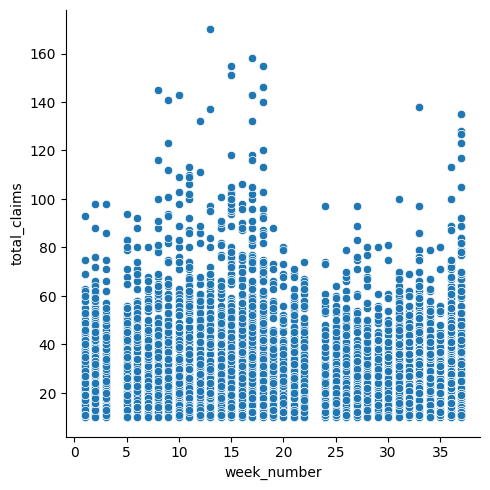

In [15]:
sns.relplot(data=unemploy_wage_data, x='week_number', y='total_claims')

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_14330/3614273883.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(unemploy_wage_data.total_claims, bins=10)


<AxesSubplot: xlabel='total_claims', ylabel='Density'>

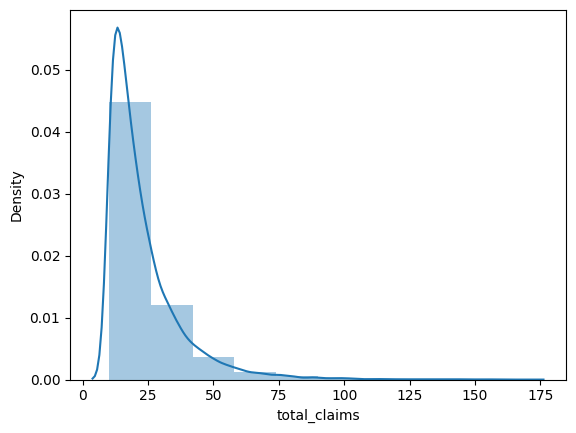

In [16]:
sns.distplot(unemploy_wage_data.total_claims, bins=10)

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_14330/3945066265.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor = unemploy_wage_data.corr()


<AxesSubplot: >

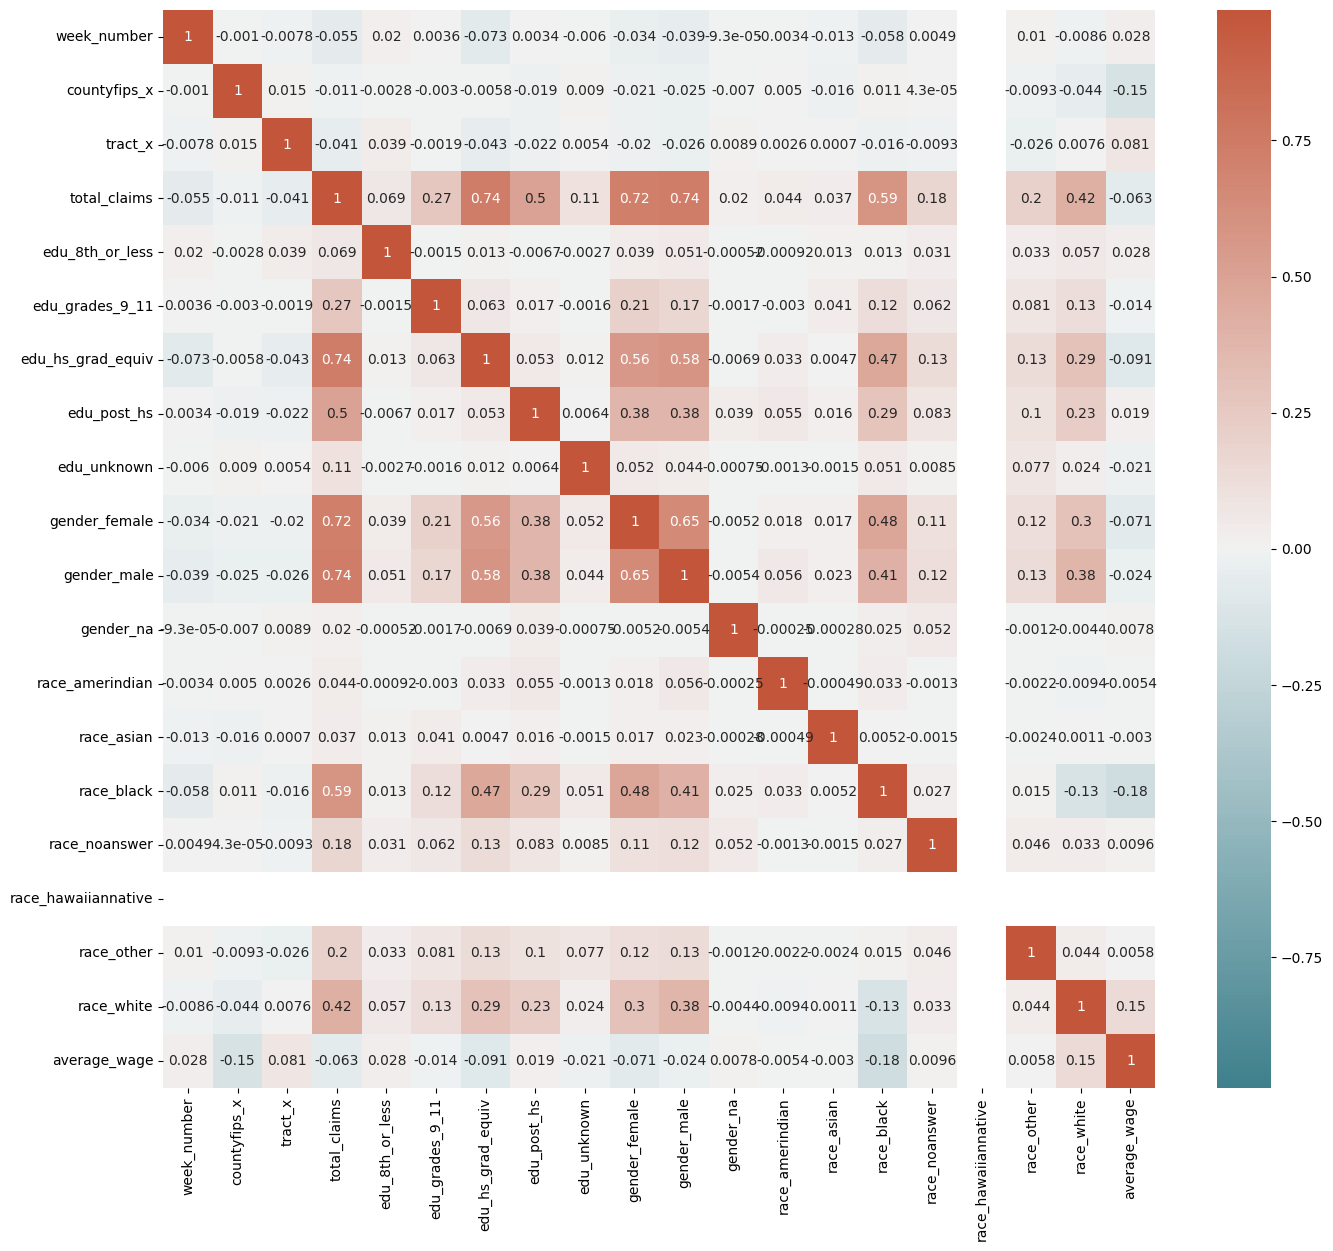

In [17]:
plt.figure(figsize=(16,14))
cor = unemploy_wage_data.corr()
cmap = sns.diverging_palette(210, 20, as_cmap=True)
sns.heatmap(cor, cmap=cmap, vmax=.99, vmin=-.99, annot=True)

In [18]:
X = unemploy_wage_data[['week_number', 'countyfips_x', 'tract_x', 'edu_8th_or_less', 'edu_grades_9_11', \
                        'edu_hs_grad_equiv', 'edu_post_hs', 'edu_unknown', 'gender_female', 'gender_male', \
                        'gender_na', 'race_amerindian', 'race_asian', 'race_black', 'race_noanswer', \
                        'race_hawaiiannative', 'race_other', 'race_white', 'average_wage']]
y = unemploy_wage_data['total_claims']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [20]:
reg = LinearRegression()  
reg.fit(X_train, y_train)
print(reg)

LinearRegression()


In [21]:
print(f'intercept: {reg.intercept_}')
coef = DataFrame(reg.coef_, X.columns, columns=['coefficients'])
print(coef)

intercept: -41.43270574771155
                     coefficients
week_number         -4.017355e-03
countyfips_x         3.032468e-03
tract_x             -4.329671e-07
edu_8th_or_less      6.494605e-01
edu_grades_9_11      6.563795e-01
edu_hs_grad_equiv    5.308050e-01
edu_post_hs          5.034803e-01
edu_unknown          6.998567e-01
gender_female        1.381438e-01
gender_male          1.938021e-01
gender_na            2.355927e-01
race_amerindian      5.257421e-02
race_asian           3.305595e-01
race_black           2.504164e-01
race_noanswer        3.173699e-01
race_hawaiiannative  1.110223e-16
race_other           3.611096e-01
race_white           1.946824e-01
average_wage        -5.541546e-06


In [22]:
y_pred = reg.predict(X_test)
df = DataFrame({'Actual': y_test, 'Predicted': y_pred})
df

,Actual,Predicted
3634,27,33.331490
752,46,31.731512
6122,21,24.823834
12636,21,21.626032
7772,41,33.011088
...,...,...
6196,39,40.238290
8309,17,22.091985
8451,18,16.718705
13667,42,40.580703


In [23]:
df['Predicted'].mean()

23.02213666707166

In [24]:
print('R squared: {:.2f}'.format(reg.score(X, y)*100))
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

R squared: 88.23
MAE: 3.436078991198356
MSE: 29.4735499906019
RMSE: 5.428954778831916


In [25]:
#Make prediction
prediction_data = pd.merge(unemploy_wage_data, prediction_list, on=['uu_id'], how='inner')
prediction_data = prediction_data.drop(['week_number_x','total_claims'],axis=1)
prediction_data = prediction_data.groupby(['uu_id']).mean()
prediction_data

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_14330/472343477.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  prediction_data = prediction_data.groupby(['uu_id']).mean()


,countyfips_x,tract_x,edu_8th_or_less,edu_grades_9_11,edu_hs_grad_equiv,edu_post_hs,edu_unknown,gender_female,gender_male,gender_na,race_amerindian,race_asian,race_black,race_noanswer,race_hawaiiannative,race_other,race_white,average_wage,week_number_y
uu_id,,,,,,,,,,,,,,,,,,,
001cd9ae23064d7f0fd3cd327c873d8d,18099.0,20102.0,0.0,0.0,2.727273,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.909091,10484.333333,44.0
005be9532fd717dc36d4be318fd9ad25,18039.0,802.0,0.0,0.0,15.764706,3.058824,0.0,8.735294,14.117647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.735294,22092.027027,44.0
007c1caccff1fbb3a0b8a10790f77141,18081.0,610900.0,0.0,0.0,6.76,0.0,0.0,0.44,0.4,0.0,0.0,0.0,3.68,0.0,0.0,0.0,10.12,8909.444444,44.0
009683350b175edfc6414d664e4ba873,18089.0,42801.0,0.0,0.0,3.478261,1.956522,0.565217,0.565217,1.478261,0.0,0.0,0.0,3.695652,0.0,0.0,0.0,4.869565,16658.000000,44.0
00f962ce727b8dbbf20925abd5a253dd,18097.0,330900.0,0.0,1.047619,16.880952,7.428571,0.238095,18.214286,12.119048,0.0,0.0,0.0,27.095238,0.0,0.0,0.285714,0.0,6953.882353,44.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fcf9f3effa992cfd552696e4ae7219b6,18097.0,330103.0,0.0,0.0,0.725,6.225,0.0,1.35,1.425,0.0,0.0,0.0,0.875,0.0,0.0,0.0,2.4,18272.333333,44.0
fcfc60d8240e5a51f878fd92e2a352a3,18157.0,1300.0,0.0,0.764706,6.029412,2.676471,0.0,0.441176,0.382353,0.0,0.0,0.0,0.882353,0.0,0.0,1.882353,3.147059,11224.545455,44.0
fd613eba867c6ad7350a937f743b88f2,18003.0,11304.0,0.0,1.028571,5.771429,3.085714,0.0,2.971429,3.028571,0.0,0.0,0.0,7.828571,0.0,0.0,0.571429,0.714286,9753.375000,44.0


In [26]:
final_reg = LinearRegression()  
final_reg.fit(X, y)
final_X = prediction_data[['week_number_y', 'countyfips_x', 'tract_x', 'edu_8th_or_less', 'edu_grades_9_11', \
                           'edu_hs_grad_equiv', 'edu_post_hs', 'edu_unknown', 'gender_female', 'gender_male', \
                           'gender_na', 'race_amerindian', 'race_asian', 'race_black', 'race_noanswer', \
                           'race_hawaiiannative', 'race_other', 'race_white', 'average_wage']]
pred_claims = final_reg.predict(final_X)
prediction_list['total_claims'] = pred_claims.astype(int)
prediction_list

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- week_number_y
Feature names seen at fit time, yet now missing:
- week_number


In [27]:
prediction_list.to_csv('submission_prediction_output.csv', index=False)